# MLP
MLP, K=5, lncRNA.

Droput.

In [1]:
from datetime import datetime
print(datetime.now())

2023-04-06 18:41:51.387089


In [2]:
import tensorflow as tf
dt='float32'
tf.keras.backend.set_floatx('float32')
# tf.random.set_seed(42) # supposedly leads to reproducible results

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print('GPU device not found')
else:
    print('Found GPU at: {}'.format(device_name))

try:
    from google.colab import drive
    IN_COLAB = True
    print('Running on CoLab')
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/Localization/TrainTest/TrainTest_ver43/'  # must end in "/"
except:
    IN_COLAB = False
    DATA_DIR = 'D:/Adjeroh/Localization/TrainTest/'   # Windows
    DATA_DIR = '/Users/jasonmiller/WVU/Localization/TrainTest/TrainTest_ver43/'    # Mac
print(DATA_DIR)

GPU device not found
Running on CoLab
Mounted at /content/drive/
/content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/


In [3]:
from platform import python_version
print('Python',python_version())
import numpy as np
import pandas as pd
import scipy.stats as ss
import pickle
import time # sleep function
from os.path import isfile
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

from tensorflow import keras
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import matthews_corrcoef
#from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix

from keras.models import Sequential
from keras.layers import Masking
from keras.layers import Embedding
from keras.layers import Conv1D
from keras.layers import GlobalAveragePooling1D
from keras.layers import GlobalMaxPooling1D
from keras.layers import AveragePooling1D
from keras.layers import MaxPooling1D
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.losses import BinaryCrossentropy
#from keras.losses import Hinge

K=5
ALPHABET=4**K + 1
CFILTERS=64 
FILTERSIZE=8
RCELLS=32
DCELLS=16
EPOCHS=120 
EMBED_DIMEN = 4 # arbitrary hyperparameter
# MINLEN=200   # NO LONGER USED
# MAXLEN=5000
PRETTY_PICTURES = True
RCI_THRESHOLD_MECHANISM = 'ZERO'  # 'RCI_GMM' 'ZERO' 'THE_MEAN'
BREAK = False   # break after first fold
EXCLUSIONS = [1]   # possibly exclude cell line 1 = H1.hESC
FILTER_TRAIN        = False
FILTER_TAILS_TRAIN  = False
FILTER_MIDDLE_TRAIN = False
FILTER_TEST         = False
FILTER_TAILS_TEST   = False
FILTER_MIDDLE_TEST  = False
REPEATS = 2
FOLDS = 5

Python 3.9.16
sklearn 1.2.2


In [4]:
RCI_FILE_TRAIN = 'train.lncRNA_RCI.csv'
RCI_FILE_TEST  = None #'test.lncRNA_RCI.csv'

SEQ_FILE_TRAIN = 'train.canon_lncRNA_transcripts.csv'
SEQ_FILE_TEST  = None #'test.canon_lncRNA_transcripts.csv'

In [5]:
def get_ordered_list():
    ordered_list = \
    ['A549','H1.hESC','HeLa.S3','HepG2','HT1080',\
      'HUVEC','MCF.7','NCI.H460','NHEK','SK.MEL.5',\
      'SK.N.DZ','SK.N.SH','GM12878','K562','IMR.90']
    return ordered_list
all_cell_lines = get_ordered_list()

## Data Load

In [6]:
class DataLoader():
    def __init__(self):
        self.cache=dict() 
        self.vals = {'A':0, 'C':1, 'G':2, 'T':3}
        self.gene2rci = dict()
        
    def load_gene_rci_values(self,filepath,exclusions):
        '''
        Load all the genes from the given RCI csv file.
        The given file usually contains train or test, not both.
        Load average RCI for each across cell lines.
        Define average as log of mean of antilogs: log2(mean(2^RCI)).
        Return dict with keys=gene:str and values=RCI:float.
        '''
        self.gene2rci = {}
        overall_sum = 0
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row # skip file's header line
                else:
                    line = row.strip()
                    fields = line.split(',')
                    gene_id = fields.pop(0)
                    cell_line_index = 0
                    rci_values = []
                    log_mean=0.0
                    for rci_str in fields:
                        if cell_line_index not in exclusions:
                            if rci_str != "nan":
                                rci_val = float(rci_str)
                                rci_values.append(rci_val)
                        cell_line_index += 1
                    if len(rci_values)>0:
                        values = np.array(rci_values)
                        antilogs = [2**x for x in values]
                        big_mean = np.mean(antilogs)
                        if np.absolute(big_mean)<0.000001:
                            log_mean = -1000000 # neg infinity
                        else:
                            log_mean = np.log2(big_mean) 
                        self.gene2rci[gene_id] = log_mean
                    # TO DO: get rid of this check on our log/antilog arithmetic.
                    if len(rci_values)==1:
                        diff = rci_values[0]-log_mean
                        if diff>0.000001:
                            print('antilog',log_mean,'not equal',rci_values,'for gene',gene_id)
        print('Number of RCI values loaded',len(self.gene2rci.keys()))
        return self.gene2rci

    def _seq_to_kmer_values(self,rna,K):
        vec=[] # seq converted to list of K-mers 
        N_indicator = 0 # indicator value
        length = len(rna)
        for i in range(length-K+1):
            kmer = rna[i:i+K]
            if 'N' in kmer:
                value = N_indicator
            elif kmer in self.cache.keys():
                value = self.cache[kmer]
            else:
                value = 0
                for j in range(K):
                    value *= 4   
                    nextnuc = kmer[j] 
                    nucval = self.vals[nextnuc]
                    value += nucval
                value += 1   # NNN => 0, AAA => 1
                self.cache[kmer] = value
            vec.append(value)
        return vec

    def load_sequence(self,filepath):
        '''
        Load all the sequences from the given file. 
        Load our version of GenCode -- csv, easier to parse than fasta.
        Each line has IDs plus sequence.
        The IDs in the file do not include dot-version numbers.
        The file may already be filtered e.g. canonical transcripts.
        '''
        allids=[]
        allseq=[]
        #NREPEAT = str('N'*MAXLEN)   # not used for MLP
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row
                else:
                    line    = row.strip()
                    fields  = line.split(',')
                    tran_id = fields[0]  # without version number
                    gene_id = fields[1]  # without version number
                    seq_len = int(fields[3])
                    seq_txt = fields[4]
                    # Keep only transcripts having numeric RCI given the cell lines in use.
                    # We have validated this by spot checking.
                    # TO DO: validate this programmatically.
                    if gene_id in self.gene2rci.keys():
                        # no MAXLEN for MLP
                        #if seq_len<=MAXLEN:
                        #    seq_txt = seq_txt + NREPEAT
                        #seq_txt = seq_txt[:MAXLEN]
                        allids.append( (gene_id,tran_id) )
                        hot_vec = self._seq_to_kmer_values(seq_txt,K)
                        allseq.append(hot_vec)
        self.cache=dict() # save RAM
        return allids,allseq

    def load_spectra(self,filepath):
        '''
        Load all (variable-length) sequences as lists of kmers.
        Then convert each sequence to (fixed-length) kmer histograms.
        '''
        allids,allseq = self.load_sequence(filepath)
        allspectra = []
        for seq in allseq:
            spectrum = np.zeros(ALPHABET)
            for kmer in seq:
                spectrum[kmer] += 1
            spectrum /= len(seq)
            allspectra.append(spectrum)
        return allids,allspectra        


## Model

In [7]:
def build_model():
    mlp    = Sequential()
    layer1 = Dense(128, activation='sigmoid',dtype=dt,input_dim=ALPHABET)
    drop1  = Dropout(.2)
    layer2 = Dense(64, activation='sigmoid')
    layer3 = Dense(64, activation='sigmoid')
    output = Dense(1, activation='sigmoid')
    mlp.add(layer1)
    mlp.add(drop1)
    mlp.add(layer2)
    mlp.add(layer3)
    mlp.add(output)
      
    bc=BinaryCrossentropy(from_logits=False)
    mlp.compile(loss=bc, optimizer="Adam", metrics=["accuracy"])
    return mlp

In [8]:
print(datetime.now())
model=build_model()
print(model.summary())  # Print this only once
model=None

2023-04-06 18:45:55.891246
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               131328    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 143,809
Trainable params: 143,809
Non-trainable params: 0
_________________________________________________________________
None


## Training

In [9]:
import gc
class CrossValidator():
    def __init__(self,epochs,score_threshold=0.5):
        self.epochs = epochs
        self.score_threshold = score_threshold
        self.mechanism = 'ZERO'
        self.discriminator = None
        self.flip = False
        self.reset_statistics()
        
    def reset_statistics(self):
        self.cv_accuracy=[]
        self.cv_precision=[]
        self.cv_recall=[]
        self.cv_f1=[]
        self.cv_auprc=[]
        self.cv_auroc=[]
        self.cv_mcc=[]
        
    def _get_X_y(self, all_ids, all_seqs, rci_map): 
        # Prepare X and y for training or testing.
        subsetX=[]
        subsetY=[]
        for t in range(len(all_ids)):
            gene_id,tran_id = all_ids[t]
            oneX            = all_seqs[t]
            oneY            = rci_map[gene_id]
            subsetX.append(oneX)
            subsetY.append(oneY)
        subsetX = np.array(subsetX)
        subsetY = np.array(subsetY).reshape((-1,1))
        return subsetX,subsetY
    
    def set_threshold_mechanism(self, mechanism):
        if mechanism not in ['RCI_GMM','THE_MEAN','ZERO']:
            raise Exception('Unrecognized mechansm:',mechanism)
        self.mechanism = mechanism
    
    def _apply_threshold(self, array_of_rci):
        # Takes list of float, returns list of labels [0,1].
        if self.mechanism == 'RCI_GMM':
            labels = self.discriminator.predict(array_of_rci)
            if self.flip:
                IS_CYTO = lambda label: 1 if label==0 else 0
                labels = np.array(list(map(IS_CYTO, labels)))
        else:  # 'THE_MEAN' or 'ZERO'
            rci_threshold = self.discriminator
            IS_CYTO = lambda rci: 1 if rci>rci_threshold else 0
            labels = np.array(list(map(IS_CYTO, array_of_rci)))
        return labels
    
    def _prepare_threshold(self, rci_values, create=True):
        if self.mechanism == 'RCI_GMM':
            if create:  # during training, create a new GMM
                gmm = GaussianMixture(n_components=2, verbose=0, 
                  covariance_type='spherical', n_init=100) # random_state=42) 
                gmm.fit(rci_values)
            else:   # during testing, use existing GMM
                gmm=self.discriminator
            self.flip = False
            # The GMM labels are arbitrary.
            if gmm.means_[0][0] > gmm.means_[1][0]:
                self.flip = True
            self.discriminator = gmm   # redundant but consistent
        elif self.mechanism == 'THE_MEAN':
            self.discriminator = np.mean(rci_values)
        elif self.mechanism == 'ZERO':
            self.discriminator = -1   # 0 usually, -1 is as in Yuan et al.
        else: # not expected
            self.discriminator = 0
    
    def _explain_threshold(self):
        if self.mechanism == 'RCI_GMM':
            gmm=self.discriminator
            print('Discriminator is GMM')
            print('Means',[gmm.means_[0][0],gmm.means_[1][0]])
            print('Variances',gmm.covariances_)
            print('Priors',gmm.weights_)
            test_rcis=[-5,-4,-3.5,-3,-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,3]
            print(test_rcis)
            print(self._apply_threshold(np.array(test_rcis).reshape((-1,1))))
        else:
            print('Discriminator',self.mechanism,self.discriminator)
    
    def _show_sizes(self,label,values):
        a = np.count_nonzero(values==1)
        b = np.count_nonzero(values==0)
        print('%s 1:0 %d:%d %5.2f%%'%(label,a,b,100*a/(a+b)))
        
    def save_model(self,filename):
        if self.model is not None:
            self.model.save(filename)
        
    def load_model(self,filename):
        self.model = keras.models.load_model(filename)
        
    def train_new_model(self,train_ids,train_seq,train_rci,
            valid_ids=None,valid_seq=None,valid_rci=None):
        print(datetime.now())
        X_train,y_rci = self._get_X_y(train_ids,train_seq,train_rci) 
        self._prepare_threshold(y_rci,True)  
        self._explain_threshold()
        y_train = self._apply_threshold(y_rci)
        self._show_sizes('Train',y_train)
        #cw = class_weight.compute_class_weight('balanced', classes=[0,1], y=y_train)
        #cwd = {0: cw[0], 1: cw[1]}
        #print('Computed class weights:',cwd)
        if valid_ids is not None:
            X_valid,y_rci = self._get_X_y(valid_ids,valid_seq,valid_rci) 
            y_valid = self._apply_threshold(y_rci)
            self._show_sizes('Valid',y_valid)
        y_rci = None

        self.model=build_model()
        print("FIT")
        print(datetime.now())
        if valid_ids is None:
            history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
            )  # no validation # class_weight=cwd)
        else:
            history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
            validation_data=(X_valid,y_valid) ) # class_weight=cwd, 

        if PRETTY_PICTURES:
            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1)
            plt.show()
        
    def test_without_training(self,test_ids,test_seq,test_rci):
        # For final test, do no train.
        # Assume set_sequences() set the test set.
        print(datetime.now())
        X_test,y_rci = self._get_X_y(test_ids,test_seq,test_rci) 
        y_test = self._apply_threshold(y_rci)
        y_rci = None
        
        print("PREDICT")
        print(datetime.now())        
        yhat_pred=self.model.predict(X_test, verbose=0)     
        yhat_classes=np.where(yhat_pred > self.score_threshold, 1, 0)

        self._show_sizes('Test',y_test)
        self._show_sizes('Predict',yhat_classes)
        print('Test sizes',X_test.shape,y_test.shape)
        print('Distrib of scores:',np.mean(yhat_pred),'mean',np.std(yhat_pred),'std')
        print('Range of scores:',np.min(yhat_pred),'to',np.max(yhat_pred))
        print('Score threshold',self.score_threshold)
        cm1 = confusion_matrix(y_test,yhat_classes)
        print('Confusion matrix\n',cm1)
        cm2 = confusion_matrix(y_test,yhat_classes,normalize='all')
        print('Normalized matrix\n',cm2)

        accuracy = accuracy_score(y_test, yhat_classes)*100.
        precision = precision_score(y_test, yhat_classes)*100.
        recall = recall_score(y_test, yhat_classes)*100.
        f1 = f1_score(y_test, yhat_classes)*100.
        prc_Y, prc_X, prc_bins = precision_recall_curve(y_test, yhat_pred)
        auprc = auc(prc_X,prc_Y)*100.
        auroc = roc_auc_score(y_test, yhat_pred)*100.
        mcc = matthews_corrcoef(y_test, yhat_classes)

        correct_pos = 0
        correct_neg = 0
        wrong_pos = 0
        wrong_neg = 0
        for i in range(len(y_test)):
            if yhat_pred[i]>=0.65:
                if y_test[i]==1:
                    correct_pos += 1
                else:
                    wrong_pos += 1
            elif yhat_pred[i]<=0.35:
                if y_test[i]==0:
                    correct_neg += 1
                else:
                    wrong_neg += 1
        print('Correct scores pos:neg',correct_pos,correct_neg)  
        print('Wrong scores pos:neg',wrong_pos,wrong_neg)  

        if PRETTY_PICTURES:
            self._pretty_pictures(y_test,yhat_pred,prc_X,prc_Y)
            print('Accuracy: %.2f%% Precision: %.2f%% Recall: %.2f%%' % (accuracy,precision,recall)) 
            print('F1: %.2f%% MCC: %.4f' % (f1,mcc)) 
            print('AUPRC: %.2f%% AUROC: %.2f%%' % (auprc,auroc)) 
        self.cv_accuracy.append(accuracy)
        self.cv_precision.append(precision)
        self.cv_recall.append(recall)
        self.cv_f1.append(f1)
        self.cv_mcc.append(mcc)
        self.cv_auprc.append(auprc)
        self.cv_auroc.append(auroc)

    def _pretty_pictures(self,y_valid,yhat_pred,prc_X,prc_Y):
        count_ones= len(y_valid[y_valid==1])
        count_zeros= len(y_valid[y_valid==0])
        guess = max(count_ones,count_zeros) / len(y_valid)
        # PRC
        plt.plot(prc_X, prc_Y, marker='.')
        plt.plot([0, 1], [guess,guess], linestyle='--')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.show()
        # ROC
        fpr, tpr, roc_bins = roc_curve(y_valid, yhat_pred)
        plt.plot(fpr, tpr, marker='.')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.show()
        
    def get_statistics(self):
        return \
        self.cv_accuracy,\
        self.cv_precision,\
        self.cv_recall,\
        self.cv_f1,\
        self.cv_mcc,\
        self.cv_auprc,\
        self.cv_auroc


## Train

In [10]:
class Separator():
    def __init__(self):
        self.train_ids = []
        self.train_seq = []
        self.train_rci = dict()
        self.val_ids = []
        self.val_seq = []
        self.val_rci = dict()
    def load(self,data_dir,rep,fold):
        filename='cv.{}.{}.validation_genes.txt'.format(rep,fold)
        filename = data_dir + filename
        self.val_genes = set()
        print('Opening file',filename)
        with open(filename,'r') as fin:
            for line in fin:
                gene_id = line.strip()
                self.val_genes.add(gene_id)
    def process(self,allids,allseq,gene_to_rci):
        size = len(allids)
        for t in range(size):
            gene_id,tran_id = allids[t]
            oneX            = allseq[t]
            oneY            = gene_to_rci[gene_id]
            in_middle = gene_to_rci[gene_id] >= -2 and gene_to_rci[gene_id] <= 0
            in_tails = gene_to_rci[gene_id] < -2 or gene_to_rci[gene_id] > 0
            if gene_id in self.val_genes:
                if FILTER_TEST and (\
                    (FILTER_TAILS_TEST and in_tails) or \
                    (FILTER_MIDDLE_TEST and in_middle)):
                    pass
                else:
                    self.val_ids.append(allids[t])
                    self.val_seq.append(allseq[t])
                    self.val_rci[gene_id]=gene_to_rci[gene_id]
            else:
                if FILTER_TRAIN and (\
                    (FILTER_TAILS_TRAIN and in_tails) or \
                    (FILTER_MIDDLE_TRAIN and in_middle)):
                    pass
                else:
                    self.train_ids.append(allids[t])
                    self.train_seq.append(allseq[t])
                    self.train_rci[gene_id]=gene_to_rci[gene_id]
    def get_ids(self):
        return self.train_ids,self.val_ids
    def get_seq(self):
        return self.train_seq,self.val_seq
    def get_rci(self):
        return self.train_rci,self.val_rci

2023-04-06 18:45:56.274341
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.lncRNA_RCI.csv
Number of RCI values loaded 4369
Num RCI: 4369
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.canon_lncRNA_transcripts.csv
Loaded 4369 sequences.

Training # 1 1
2023-04-06 18:46:05.877232
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.1.1.validation_genes.txt
2023-04-06 18:46:06.130179
Discriminator ZERO -1
Train 1:0 1800:1699 51.44%
Valid 1:0 458:412 52.64%
FIT
2023-04-06 18:46:06.258992


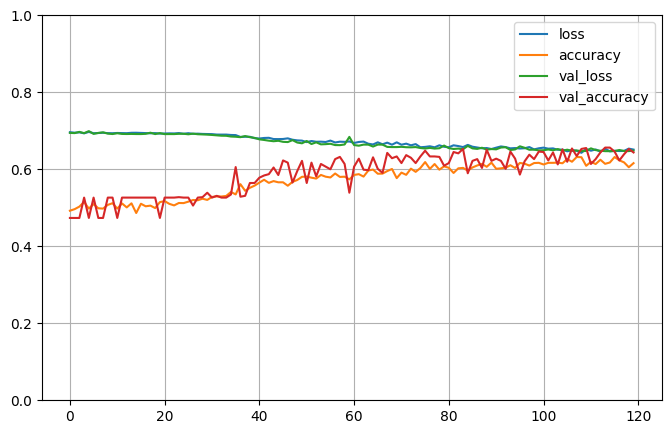


Testing # 1 1
2023-04-06 18:47:22.507969
2023-04-06 18:47:22.508022
PREDICT
2023-04-06 18:47:22.525912
Test 1:0 458:412 52.64%
Predict 1:0 578:292 66.44%
Test sizes (870, 1025) (870,)
Distrib of scores: 0.55060303 mean 0.11636758 std
Range of scores: 0.19252165 to 0.83380336
Score threshold 0.5
Confusion matrix
 [[197 215]
 [ 95 363]]
Normalized matrix
 [[0.22643678 0.24712644]
 [0.1091954  0.41724138]]
Correct scores pos:neg 128 28
Wrong scores pos:neg 53 10


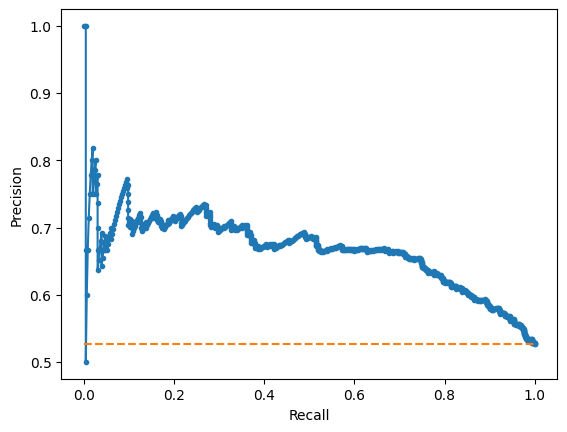

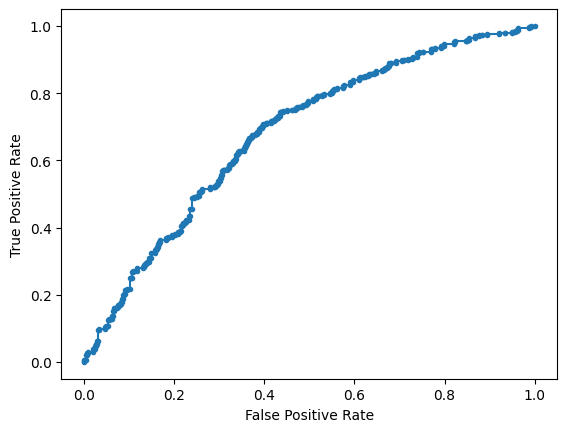

Accuracy: 64.37% Precision: 62.80% Recall: 79.26%
F1: 70.08% MCC: 0.2863
AUPRC: 66.65% AUROC: 68.04%
 accuracy [64.36781609195403]
 precision [62.80276816608996]
 recall [79.25764192139738]
 F1 [70.07722007722008]
 MCC [0.28626299259932003]
 AUPRC [66.65434805082609]
 AUROC [68.0364183660491]

Training # 1 2
2023-04-06 18:47:23.160000
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.1.2.validation_genes.txt
2023-04-06 18:47:23.409941
Discriminator ZERO -1
Train 1:0 1816:1669 52.11%
Valid 1:0 442:442 50.00%
FIT
2023-04-06 18:47:23.498730


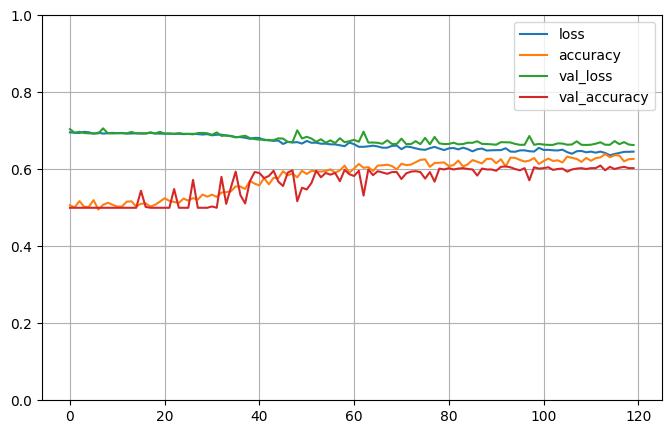


Testing # 1 2
2023-04-06 18:48:46.721356
2023-04-06 18:48:46.721407
PREDICT
2023-04-06 18:48:46.735340
Test 1:0 442:442 50.00%
Predict 1:0 481:403 54.41%
Test sizes (884, 1025) (884,)
Distrib of scores: 0.50962305 mean 0.13505271 std
Range of scores: 0.15972403 to 0.8251458
Score threshold 0.5
Confusion matrix
 [[247 195]
 [156 286]]
Normalized matrix
 [[0.27941176 0.22058824]
 [0.17647059 0.32352941]]
Correct scores pos:neg 93 85
Wrong scores pos:neg 52 36


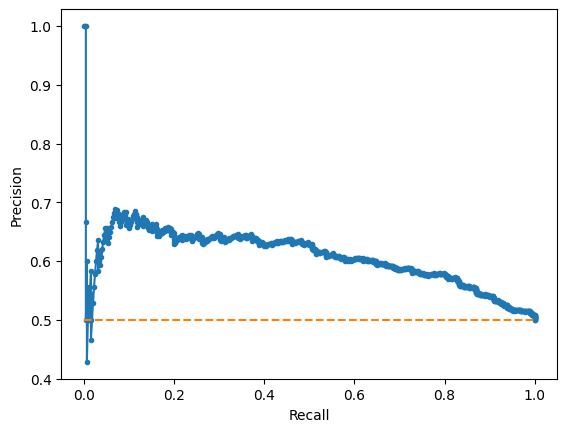

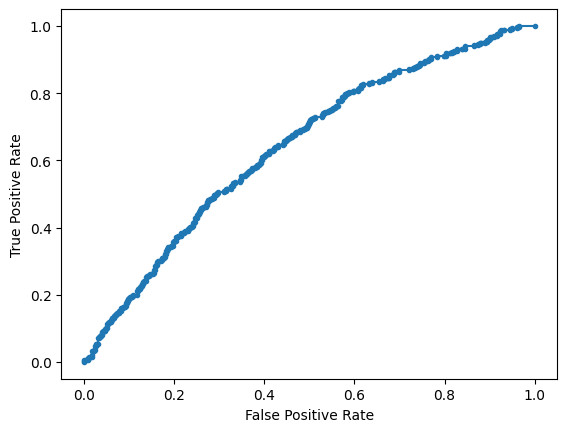

Accuracy: 60.29% Precision: 59.46% Recall: 64.71%
F1: 61.97% MCC: 0.2067
AUPRC: 60.78% AUROC: 64.12%
 accuracy [60.29411764705882]
 precision [59.45945945945946]
 recall [64.70588235294117]
 F1 [61.9718309859155]
 MCC [0.20668850837512243]
 AUPRC [60.77833297592402]
 AUROC [64.12235621711268]

Training # 1 3
2023-04-06 18:48:47.351101
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.1.3.validation_genes.txt
2023-04-06 18:48:47.556696
Discriminator ZERO -1
Train 1:0 1816:1704 51.59%
Valid 1:0 442:407 52.06%
FIT
2023-04-06 18:48:47.653885


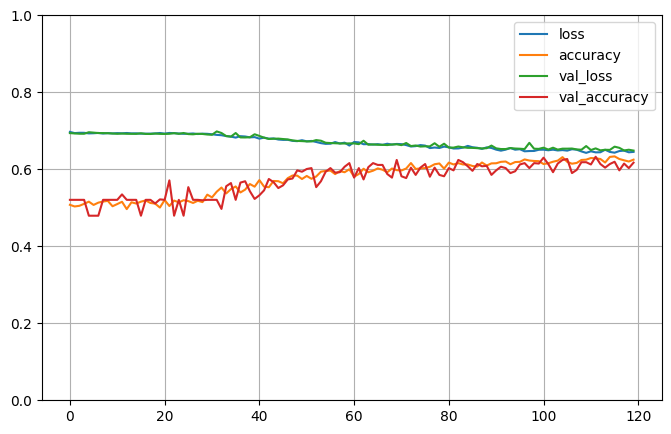


Testing # 1 3
2023-04-06 18:50:11.082344
2023-04-06 18:50:11.082389
PREDICT
2023-04-06 18:50:11.093902
Test 1:0 442:407 52.06%
Predict 1:0 483:366 56.89%
Test sizes (849, 1025) (849,)
Distrib of scores: 0.5240323 mean 0.1259087 std
Range of scores: 0.11999262 to 0.80852556
Score threshold 0.5
Confusion matrix
 [[224 183]
 [142 300]]
Normalized matrix
 [[0.26383981 0.2155477 ]
 [0.16725559 0.35335689]]
Correct scores pos:neg 108 58
Wrong scores pos:neg 42 11


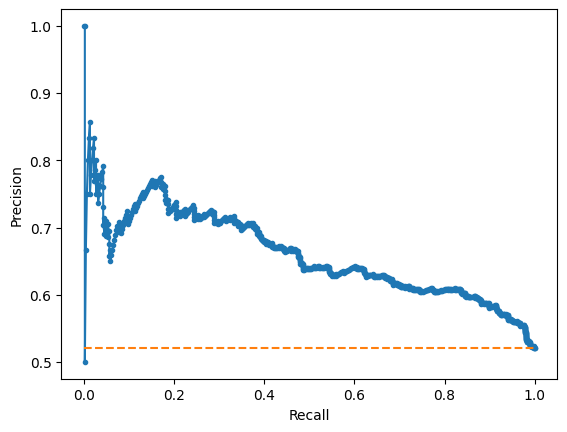

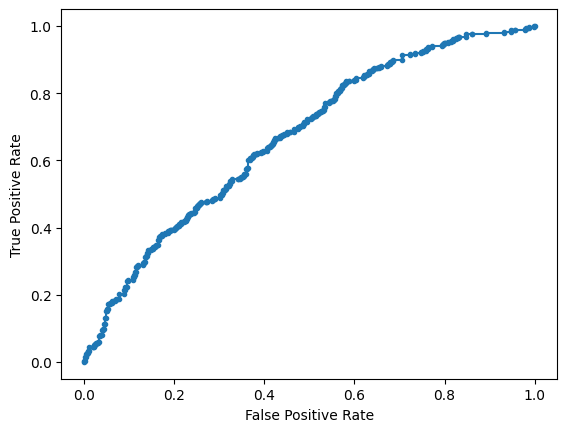

Accuracy: 61.72% Precision: 62.11% Recall: 67.87%
F1: 64.86% MCC: 0.2311
AUPRC: 65.97% AUROC: 66.86%
 accuracy [61.71967020023557]
 precision [62.11180124223602]
 recall [67.87330316742081]
 F1 [64.86486486486486]
 MCC [0.2311119060833508]
 AUPRC [65.97497007530667]
 AUROC [66.85714921009038]

Training # 1 4
2023-04-06 18:50:11.719162
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.1.4.validation_genes.txt
2023-04-06 18:50:11.940664
Discriminator ZERO -1
Train 1:0 1799:1680 51.71%
Valid 1:0 459:431 51.57%
FIT
2023-04-06 18:50:12.027290


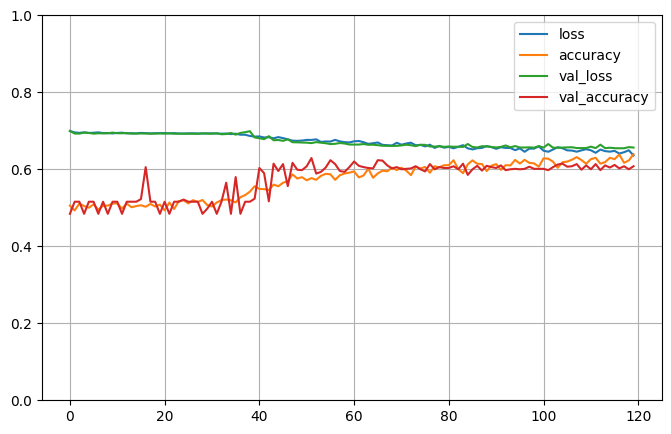


Testing # 1 4
2023-04-06 18:52:35.186717
2023-04-06 18:52:35.187153
PREDICT
2023-04-06 18:52:35.195283
Test 1:0 459:431 51.57%
Predict 1:0 572:318 64.27%
Test sizes (890, 1025) (890,)
Distrib of scores: 0.54704654 mean 0.12796268 std
Range of scores: 0.1808561 to 0.8809683
Score threshold 0.5
Confusion matrix
 [[200 231]
 [118 341]]
Normalized matrix
 [[0.2247191  0.25955056]
 [0.13258427 0.38314607]]
Correct scores pos:neg 138 44
Wrong scores pos:neg 59 10


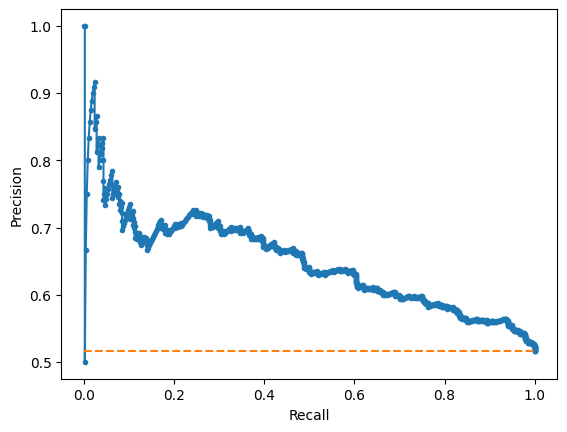

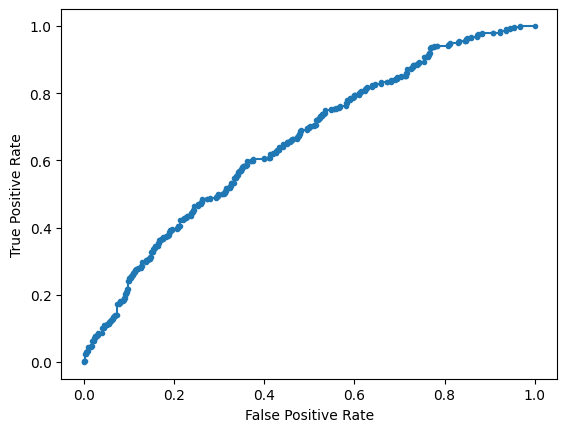

Accuracy: 60.79% Precision: 59.62% Recall: 74.29%
F1: 66.15% MCC: 0.2158
AUPRC: 64.90% AUROC: 65.30%
 accuracy [60.78651685393258]
 precision [59.61538461538461]
 recall [74.29193899782135]
 F1 [66.14936954413191]
 MCC [0.21583034339652796]
 AUPRC [64.90072818141884]
 AUROC [65.29679672848773]

Training # 1 5
2023-04-06 18:52:35.868185
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.1.5.validation_genes.txt
2023-04-06 18:52:36.104708
Discriminator ZERO -1
Train 1:0 1801:1692 51.56%
Valid 1:0 457:419 52.17%
FIT
2023-04-06 18:52:36.184706


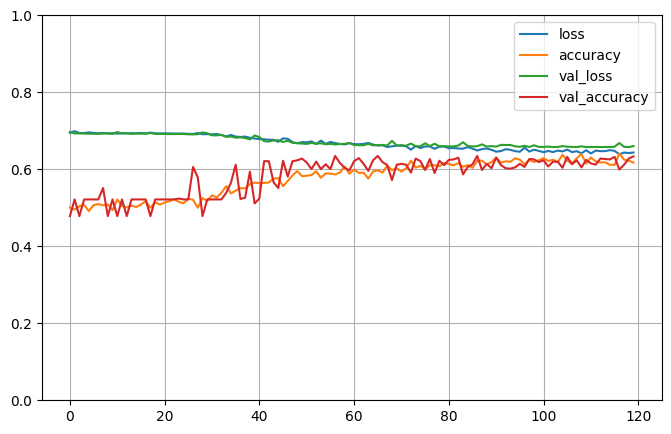


Testing # 1 5
2023-04-06 18:53:59.357532
2023-04-06 18:53:59.357580
PREDICT
2023-04-06 18:53:59.370314
Test 1:0 457:419 52.17%
Predict 1:0 418:458 47.72%
Test sizes (876, 1025) (876,)
Distrib of scores: 0.4871622 mean 0.13389292 std
Range of scores: 0.14186123 to 0.8105448
Score threshold 0.5
Confusion matrix
 [[278 141]
 [180 277]]
Normalized matrix
 [[0.3173516  0.1609589 ]
 [0.20547945 0.31621005]]
Correct scores pos:neg 70 102
Wrong scores pos:neg 34 48


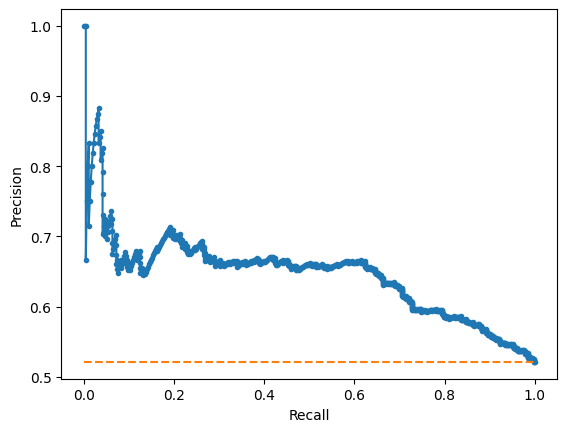

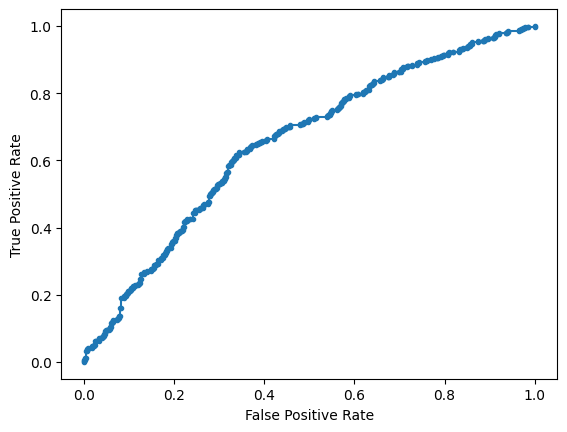

Accuracy: 63.36% Precision: 66.27% Recall: 60.61%
F1: 63.31% MCC: 0.2696
AUPRC: 64.55% AUROC: 65.25%
 accuracy [63.35616438356164]
 precision [66.26794258373205]
 recall [60.61269146608315]
 F1 [63.31428571428571]
 MCC [0.26963886206903065]
 AUPRC [64.55339421128824]
 AUROC [65.25174558577001]

Training # 2 1
2023-04-06 18:53:59.994595
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.2.1.validation_genes.txt
2023-04-06 18:54:00.179484
Discriminator ZERO -1
Train 1:0 1786:1696 51.29%
Valid 1:0 472:415 53.21%
FIT
2023-04-06 18:54:00.269658


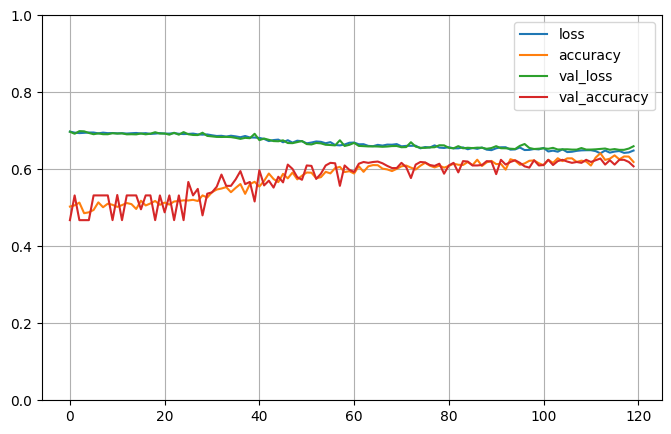


Testing # 2 1
2023-04-06 18:55:12.619314
2023-04-06 18:55:12.621244
PREDICT
2023-04-06 18:55:12.629043
Test 1:0 472:415 53.21%
Predict 1:0 348:539 39.23%
Test sizes (887, 1025) (887,)
Distrib of scores: 0.4640732 mean 0.12981595 std
Range of scores: 0.10299194 to 0.77143145
Score threshold 0.5
Confusion matrix
 [[303 112]
 [236 236]]
Normalized matrix
 [[0.3416009  0.12626832]
 [0.26606539 0.26606539]]
Correct scores pos:neg 53 117
Wrong scores pos:neg 23 63


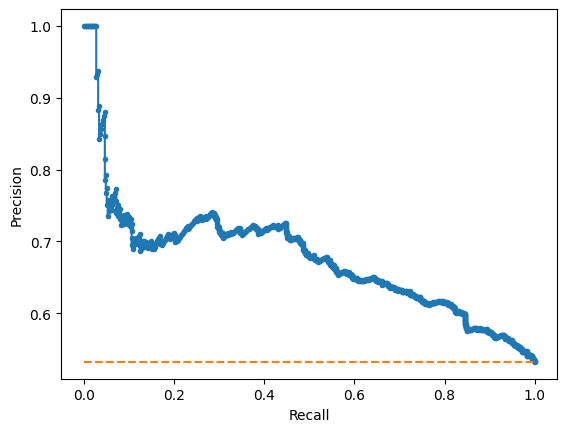

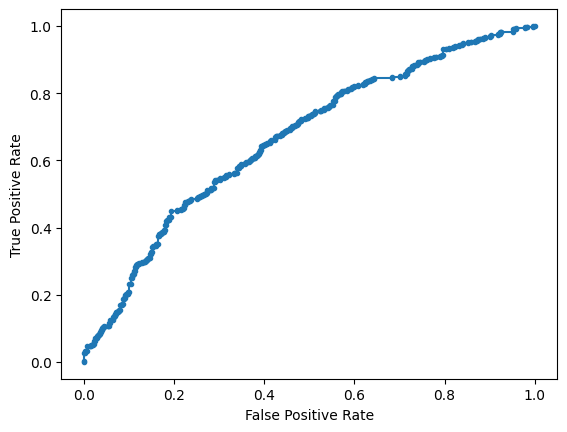

Accuracy: 60.77% Precision: 67.82% Recall: 50.00%
F1: 57.56% MCC: 0.2352
AUPRC: 67.66% AUROC: 66.51%
 accuracy [60.766629086809466]
 precision [67.81609195402298]
 recall [50.0]
 F1 [57.56097560975609]
 MCC [0.23516155212472364]
 AUPRC [67.66139082642553]
 AUROC [66.50500306309985]

Training # 2 2
2023-04-06 18:55:13.266883
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.2.2.validation_genes.txt
2023-04-06 18:55:13.519332
Discriminator ZERO -1
Train 1:0 1806:1695 51.59%
Valid 1:0 452:416 52.07%
FIT
2023-04-06 18:55:13.604803


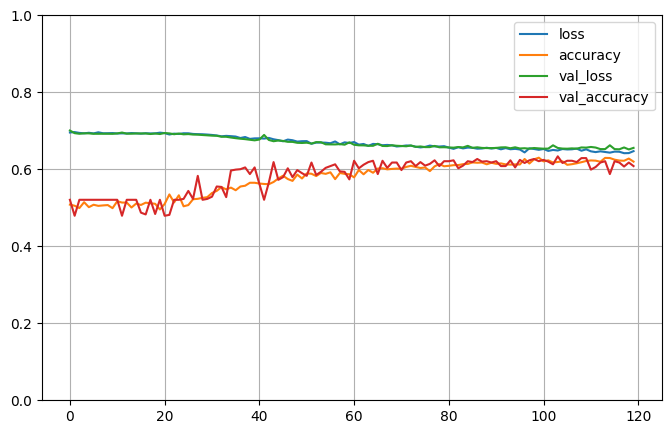


Testing # 2 2
2023-04-06 18:56:36.832748
2023-04-06 18:56:36.833273
PREDICT
2023-04-06 18:56:36.841260
Test 1:0 452:416 52.07%
Predict 1:0 362:506 41.71%
Test sizes (868, 1025) (868,)
Distrib of scores: 0.47659492 mean 0.13272673 std
Range of scores: 0.13069586 to 0.82764834
Score threshold 0.5
Confusion matrix
 [[291 125]
 [215 237]]
Normalized matrix
 [[0.33525346 0.14400922]
 [0.24769585 0.27304147]]
Correct scores pos:neg 67 122
Wrong scores pos:neg 26 49


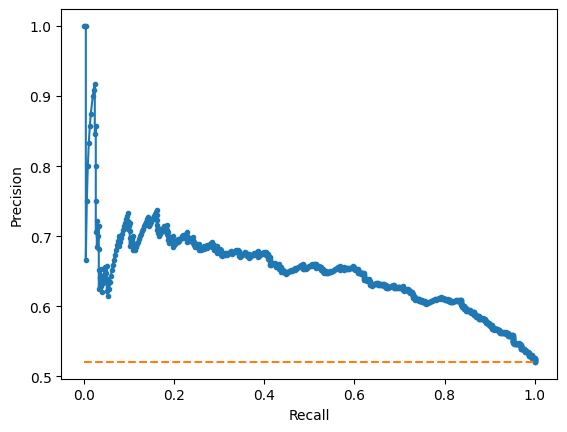

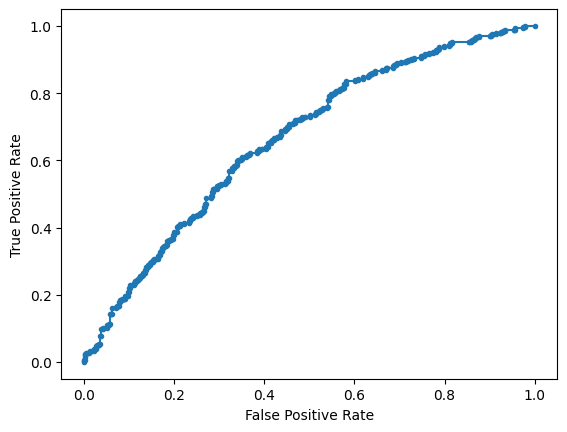

Accuracy: 60.83% Precision: 65.47% Recall: 52.43%
F1: 58.23% MCC: 0.2268
AUPRC: 65.05% AUROC: 66.37%
 accuracy [60.82949308755761]
 precision [65.4696132596685]
 recall [52.43362831858407]
 F1 [58.23095823095823]
 MCC [0.22680578900459705]
 AUPRC [65.04539992837667]
 AUROC [66.37274506466984]

Training # 2 3
2023-04-06 18:56:37.492729
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.2.3.validation_genes.txt
2023-04-06 18:56:37.742493
Discriminator ZERO -1
Train 1:0 1805:1704 51.44%
Valid 1:0 453:407 52.67%
FIT
2023-04-06 18:56:37.827513


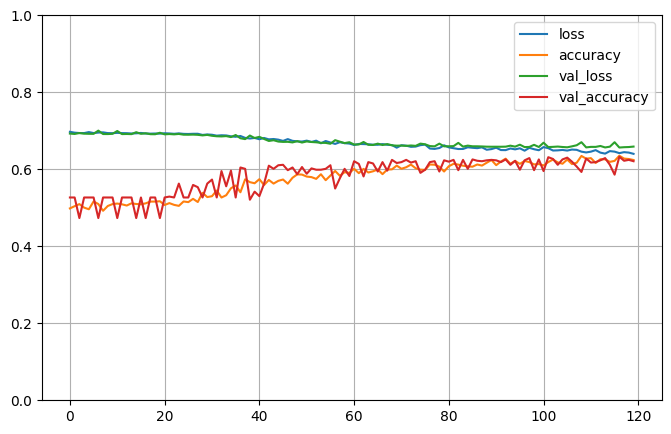


Testing # 2 3
2023-04-06 18:58:01.447998
2023-04-06 18:58:01.448055
PREDICT
2023-04-06 18:58:01.461966
Test 1:0 453:407 52.67%
Predict 1:0 577:283 67.09%
Test sizes (860, 1025) (860,)
Distrib of scores: 0.5616943 mean 0.12702218 std
Range of scores: 0.17929311 to 0.8579673
Score threshold 0.5
Confusion matrix
 [[182 225]
 [101 352]]
Normalized matrix
 [[0.21162791 0.26162791]
 [0.11744186 0.40930233]]
Correct scores pos:neg 150 33
Wrong scores pos:neg 76 9


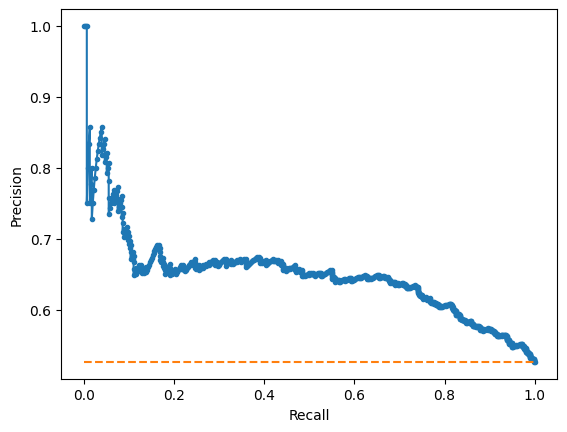

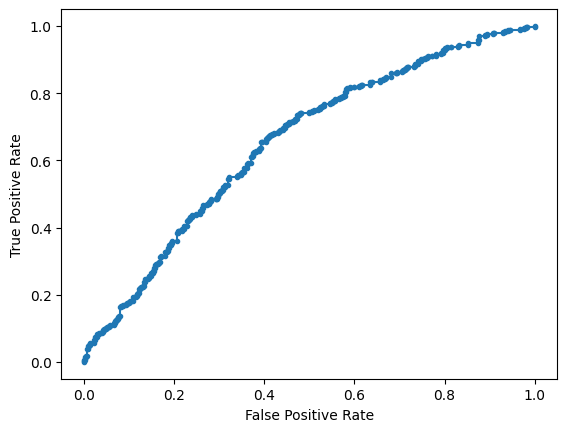

Accuracy: 62.09% Precision: 61.01% Recall: 77.70%
F1: 68.35% MCC: 0.2382
AUPRC: 64.95% AUROC: 65.30%
 accuracy [62.093023255813954]
 precision [61.005199306759096]
 recall [77.70419426048565]
 F1 [68.3495145631068]
 MCC [0.2382497956305948]
 AUPRC [64.95033514677584]
 AUROC [65.29714542959577]

Training # 2 4
2023-04-06 18:58:03.033061
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.2.4.validation_genes.txt
2023-04-06 18:58:03.266689
Discriminator ZERO -1
Train 1:0 1826:1664 52.32%
Valid 1:0 432:447 49.15%
FIT
2023-04-06 18:58:03.606496


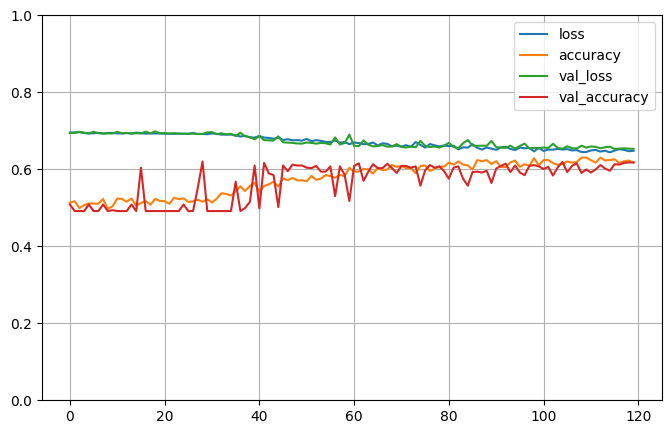


Testing # 2 4
2023-04-06 18:59:24.898611
2023-04-06 18:59:24.899238
PREDICT
2023-04-06 18:59:24.908297
Test 1:0 432:447 49.15%
Predict 1:0 448:431 50.97%
Test sizes (879, 1025) (879,)
Distrib of scores: 0.49637413 mean 0.1271554 std
Range of scores: 0.14244866 to 0.8003255
Score threshold 0.5
Confusion matrix
 [[271 176]
 [160 272]]
Normalized matrix
 [[0.30830489 0.20022753]
 [0.18202503 0.30944255]]
Correct scores pos:neg 83 89
Wrong scores pos:neg 28 33


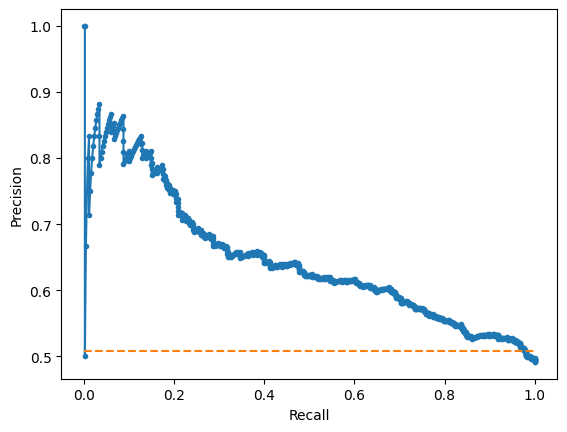

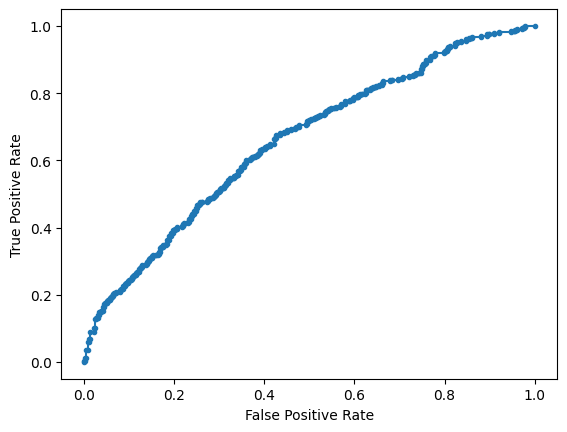

Accuracy: 61.77% Precision: 60.71% Recall: 62.96%
F1: 61.82% MCC: 0.2359
AUPRC: 64.50% AUROC: 65.67%
 accuracy [61.774744027303754]
 precision [60.71428571428571]
 recall [62.96296296296296]
 F1 [61.81818181818181]
 MCC [0.23590338504730324]
 AUPRC [64.50329632756362]
 AUROC [65.67083022619936]

Training # 2 5
2023-04-06 18:59:25.545520
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.2.5.validation_genes.txt
2023-04-06 18:59:25.771731
Discriminator ZERO -1
Train 1:0 1809:1685 51.77%
Valid 1:0 449:426 51.31%
FIT
2023-04-06 18:59:25.854100


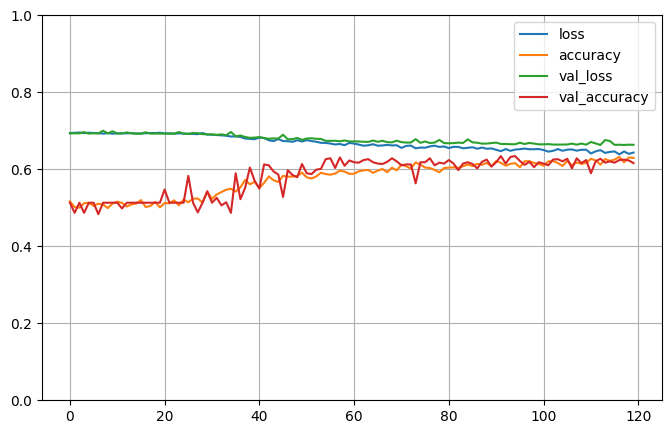


Testing # 2 5
2023-04-06 19:00:49.038855
2023-04-06 19:00:49.038947
PREDICT
2023-04-06 19:00:49.061476
Test 1:0 449:426 51.31%
Predict 1:0 501:374 57.26%
Test sizes (875, 1025) (875,)
Distrib of scores: 0.5357169 mean 0.13346672 std
Range of scores: 0.19125965 to 0.87637776
Score threshold 0.5
Confusion matrix
 [[232 194]
 [142 307]]
Normalized matrix
 [[0.26514286 0.22171429]
 [0.16228571 0.35085714]]
Correct scores pos:neg 109 56
Wrong scores pos:neg 60 9


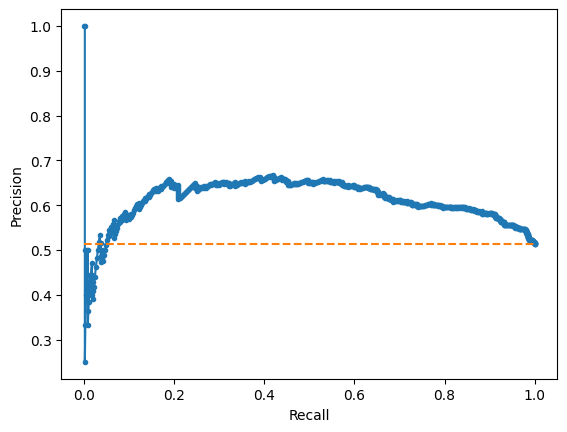

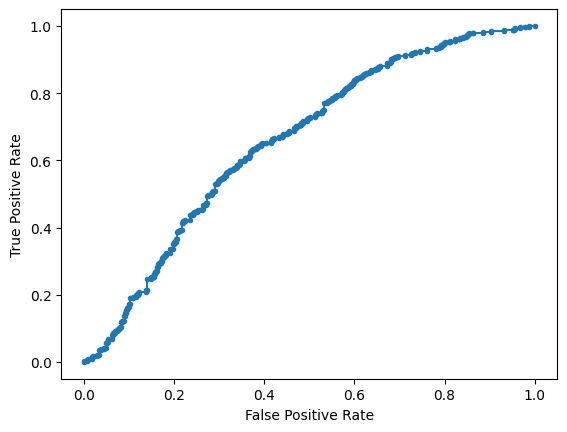

Accuracy: 61.60% Precision: 61.28% Recall: 68.37%
F1: 64.63% MCC: 0.2307
AUPRC: 61.06% AUROC: 65.83%
 accuracy [61.6]
 precision [61.27744510978044]
 recall [68.37416481069042]
 F1 [64.63157894736842]
 MCC [0.2307067085492153]
 AUPRC [61.06449936808129]
 AUROC [65.83121595198511]
2023-04-06 19:00:49.699170


In [11]:
print(datetime.now())

accuracy=[]
precision=[]
recall=[]
f1=[]
mcc=[]
auprc=[]
auroc=[]

loader = DataLoader()
filepath = DATA_DIR+RCI_FILE_TRAIN
print("Load RCI from",filepath)
gene_to_rci = loader.load_gene_rci_values(filepath,EXCLUSIONS)
print('Num RCI:', len(gene_to_rci.keys()))
filepath = DATA_DIR+SEQ_FILE_TRAIN
print('Load sequence from',filepath)
allids,allseq = loader.load_spectra(filepath)  # for MLP (load_sequence() for CNN)
print('Loaded',len(allseq),'sequences.')
test_gene_to_rci = None
test_allids = None
test_allseq = None
if SEQ_FILE_TEST is not None:
    # Train on the entire train set (no cross-validation).
    # Evaluate with the test files.
    test_loader = DataLoader()
    filepath = DATA_DIR+RCI_FILE_TEST
    print("Load RCI from",filepath)
    test_gene_to_rci = test_loader.load_gene_rci_values(filepath,EXCLUSIONS)
    print('Num RCI:', len(test_gene_to_rci.keys()))
    filepath = DATA_DIR+SEQ_FILE_TEST
    print('Load sequence from',filepath)
    test_allids,test_allseq = test_loader.load_spectra(filepath)
    print('Loaded',len(test_allseq),'sequences.')

for repeat in range(REPEATS):
    for fold in range(FOLDS):
        show_r = repeat+1  # display one-based counting
        show_f = fold+1    # display one-based counting

        print()
        print("Training #",show_r,show_f)
        print(datetime.now())
        cvdo = CrossValidator(EPOCHS)
        cvdo.set_threshold_mechanism(RCI_THRESHOLD_MECHANISM)
        if SEQ_FILE_TEST is None:
            # Train on 80% and evaluate on 20%.
            separator = Separator()
            separator.load(DATA_DIR,show_r,show_f)
            separator.process(allids,allseq,gene_to_rci)
            train_allids,test_allids = separator.get_ids()
            train_allseq,test_allseq = separator.get_seq()
            train_gene_to_rci,test_gene_to_rci = separator.get_rci()
            cvdo.train_new_model(
                train_allids,train_allseq,train_gene_to_rci,
                test_allids,test_allseq,test_gene_to_rci)
        else:
            # Train on the entire train set (no cross-validation).
            # Evaluate with the test files.
            train_allids = allids
            train_allseq = allseq
            train_gene_to_rci = gene_to_rci
            BREAK = True
            cvdo.train_new_model(
                train_allids,train_allseq,train_gene_to_rci,
                None,None,None)
           
        print()
        print("Testing #",show_r,show_f)
        print(datetime.now())
        cvdo.reset_statistics()
        cvdo.test_without_training(
            test_allids,test_allseq,test_gene_to_rci)
        cv_accuracy,cv_precision,cv_recall,cv_f1,cv_mcc,cv_auprc,cv_auroc=\
            cvdo.get_statistics()

        print(" accuracy" ,  cv_accuracy)
        print(" precision" , cv_precision)
        print(" recall" ,    cv_recall)
        print(" F1" ,        cv_f1)
        print(" MCC" ,       cv_mcc)
        print(" AUPRC" ,     cv_auprc)
        print(" AUROC" ,     cv_auroc)

        accuracy.append(cv_accuracy)
        precision.append(cv_precision)
        recall.append(cv_recall)
        f1.append(cv_f1)
        mcc.append(cv_mcc)
        auprc.append(cv_auprc)
        auroc.append(cv_auroc)
        if BREAK: break
    if BREAK: break
print(datetime.now())

In [12]:
def STD (values):
    # ddof=1 reduces bias when extrapolating from sample to population
    return np.std(values,ddof=1)

print(" accuracy mean %.2f%% std %.2f" %  (np.mean(accuracy),  STD(accuracy)))
print(" precision mean %.2f%% std %.2f" % (np.mean(precision), STD(precision)))
print(" recall mean %.2f%% std %.2f" %    (np.mean(recall),    STD(recall)))
print(" F1 mean %.2f%% std %.2f" %        (np.mean(f1),        STD(f1)))
print(" MCC mean %.4f std %.4f" %       (np.mean(mcc),       STD(mcc)))
print(" AUPRC mean %.2f%% std %.2f" %     (np.mean(auprc),     STD(auprc)))
print(" AUROC mean %.2f%% std %.2f" %     (np.mean(auroc),     STD(auroc)))

print(" accuracy"  , accuracy)
print(" precision" , precision)
print(" recall"    , recall)
print(" F1"        , f1)
print(" MCC"       , mcc)
print(" AUPRC"     , auprc)
print(" AUROC"     , auroc)



 accuracy mean 61.76% std 1.27
 precision mean 62.65% std 2.90
 recall mean 65.82% std 9.83
 F1 mean 63.70% std 4.01
 MCC mean 0.2376 std 0.0237
 AUPRC mean 64.61% std 2.19
 AUROC mean 65.92% std 1.08
 accuracy [[64.36781609195403], [60.29411764705882], [61.71967020023557], [60.78651685393258], [63.35616438356164], [60.766629086809466], [60.82949308755761], [62.093023255813954], [61.774744027303754], [61.6]]
 precision [[62.80276816608996], [59.45945945945946], [62.11180124223602], [59.61538461538461], [66.26794258373205], [67.81609195402298], [65.4696132596685], [61.005199306759096], [60.71428571428571], [61.27744510978044]]
 recall [[79.25764192139738], [64.70588235294117], [67.87330316742081], [74.29193899782135], [60.61269146608315], [50.0], [52.43362831858407], [77.70419426048565], [62.96296296296296], [68.37416481069042]]
 F1 [[70.07722007722008], [61.9718309859155], [64.86486486486486], [66.14936954413191], [63.31428571428571], [57.56097560975609], [58.23095823095823], [68.34951